Task 1

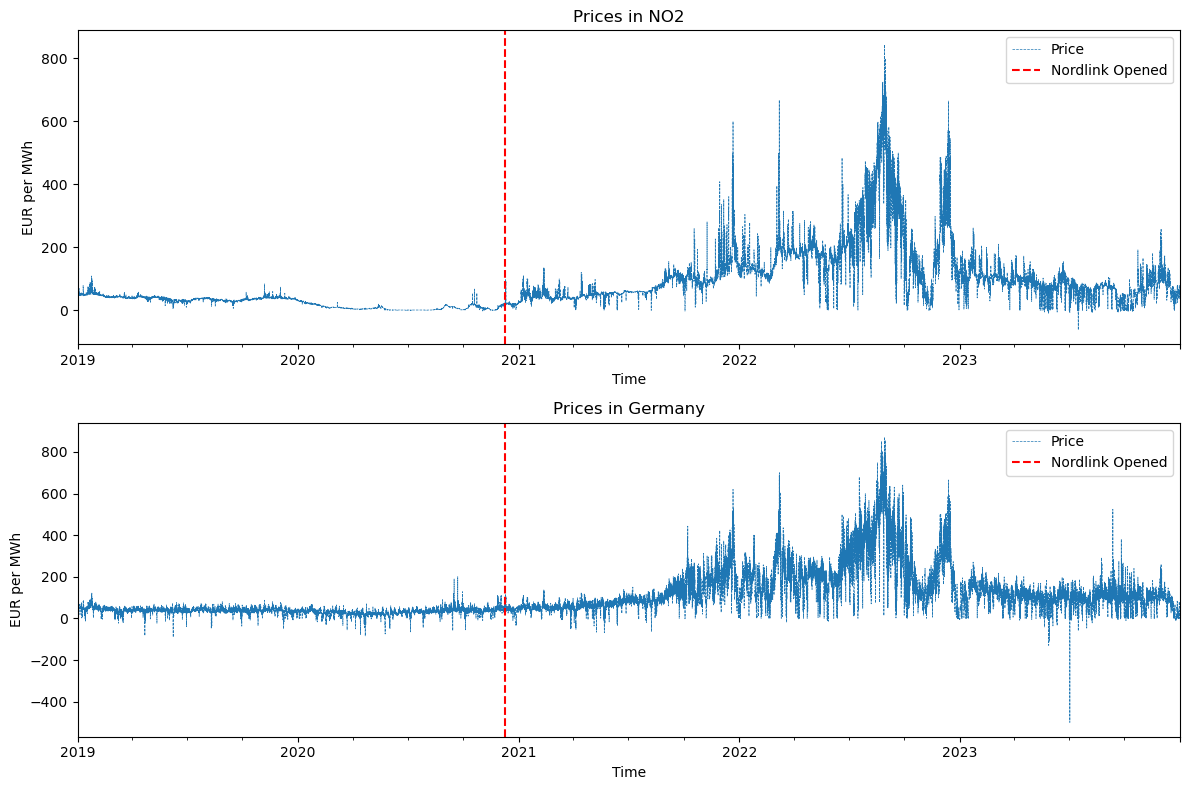

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

DATA_PATH = './data'  # Adjust as needed (relative or absolute)
day_ahead_pattern = f'{DATA_PATH}/DayAheadPrices_12.1.D/*.D.csv'

# Initialize list to store data from each file
dayahead_data = [] 
for file in glob.glob(day_ahead_pattern):
    # Read each file
    d = pd.read_csv(file, sep="\t", parse_dates=['DateTime'], index_col='DateTime')
    
    # Filter rows to keep only those with hourly data and relevant map codes
    d = d[(d['ResolutionCode'] == 'PT60M') & (d['MapCode'].isin(['NO2', 'DE_LU']))]
    
    # Append to list
    dayahead_data.append(d)

# Concatenate all data and sort by index
df = pd.concat(dayahead_data, axis=0).sort_index()

# Filter out rows with incomplete hours or minutes using the index
df = df[(df.index.hour.notnull()) & (df.index.minute.notnull())]

# Separate data for NO2 and DE_LU
dfno = df.loc[df['MapCode'] == 'NO2']
dfde = df.loc[df['MapCode'] == 'DE_LU']

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# NO2 Plot
dfno['Price'].plot(ax=ax1, lw=0.5, ls='--', title="Prices in NO2", xlabel='Time', ylabel='EUR per MWh')
ax1.axvline(pd.to_datetime("2020-12-09"), color='red', linestyle='--', label='Nordlink Opened')
ax1.legend()

# Germany Plot
dfde['Price'].plot(ax=ax2, lw=0.5, ls='--', title="Prices in Germany", xlabel='Time', ylabel='EUR per MWh')
ax2.axvline(pd.to_datetime("2020-12-09"), color='red', linestyle='--', label='Nordlink Opened')
ax2.legend()

# Adjust layout and save the figure
plt.tight_layout()  # Adjust spacing between plots
plt.savefig('figure_task1.png', format='png', dpi=300)
plt.show()

It is clear that the price of energy has increased in both NO2 and Germany after the opening of Nordlink. The prices increased heavilly in the end of 2021, and became very volatile. The reason for the negative electricity prices can be that certain natural energy storages, such as hydro-power, have reached full capacaty and they have to produce more energy than the demand, thus making the making the market-equilibrium at a negative price. 

TASK 2


In [33]:
# Add a 'Year' column based on the DateTime index
# Use .loc to assign the 'Year' column explicitly
dfde.loc[:, 'Year'] = dfde.index.year
dfno.loc[:, 'Year'] = dfno.index.year

stats_no2 = dfno.groupby('Year')['Price'].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
stats_no2['Zone'] = 'NO2'

stats_de = dfde.groupby('Year')['Price'].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
stats_de['Zone'] = 'Germany'

# Concatenate the two DataFrames
all_stats = pd.concat([stats_no2, stats_de]).sort_index()

# Save to a single Excel file
#all_stats.to_excel("table_task2.xlsx", index=True)
print(all_stats)

        mean  median     std     min     max     Zone
Year                                                 
2019   39.26   38.81    8.23    5.86  109.45      NO2
2019   37.67   38.06   15.52  -90.01  121.46  Germany
2020    9.29    6.95    8.26   -1.73   99.92      NO2
2020   30.47   30.99   17.50  -83.94  200.04  Germany
2021   75.11   59.34   47.22   -1.97  600.16      NO2
2021   96.85   75.48   73.68  -69.00  620.00  Germany
2022  211.28  181.13  125.85    0.04  844.00      NO2
2022  235.44  208.34  142.82  -19.04  871.00  Germany
2023   79.44   80.46   36.28  -61.84  261.85      NO2
2023   95.18   98.02   47.58 -500.00  524.27  Germany


Year
2019    8760
2020    8784
2021    8760
2022    8760
2023    8760
Name: Price, dtype: int64

The statistics suggests that electricity prices have indeed become more extreme and volatile in both NO2 and Germany, especially after the introduction of NordLink. Germany appears to have experienced more frequent extreme low prices, while NO2's prices show volatility primarily at the high end. Both regions experienced a substantial increase in the mean and median prices from 2019 to 2022. While the increase might be caused by NordLink, it is likely that the european energy crises also have led to this increase. There was a slight decrease in mean and median prices in 2023 for both NO2 and Germany, but the prices remained elevated compared to the early years in the sample (2019 & 2020). The increase in standard deviation also indicates increased volatility. 


TASK 3

/var/folders/wr/mv2w9z0x5h3627lllc7pwsr00000gn/T/ipykernel_68902/341343536.py:19: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  exports_per_year = physicalflow_export['FlowValue'].resample('Y').sum()
/var/folders/wr/mv2w9z0x5h3627lllc7pwsr00000gn/T/ipykernel_68902/341343536.py:20: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  imports_per_year = physicalflow_import['FlowValue'].resample('Y').sum()


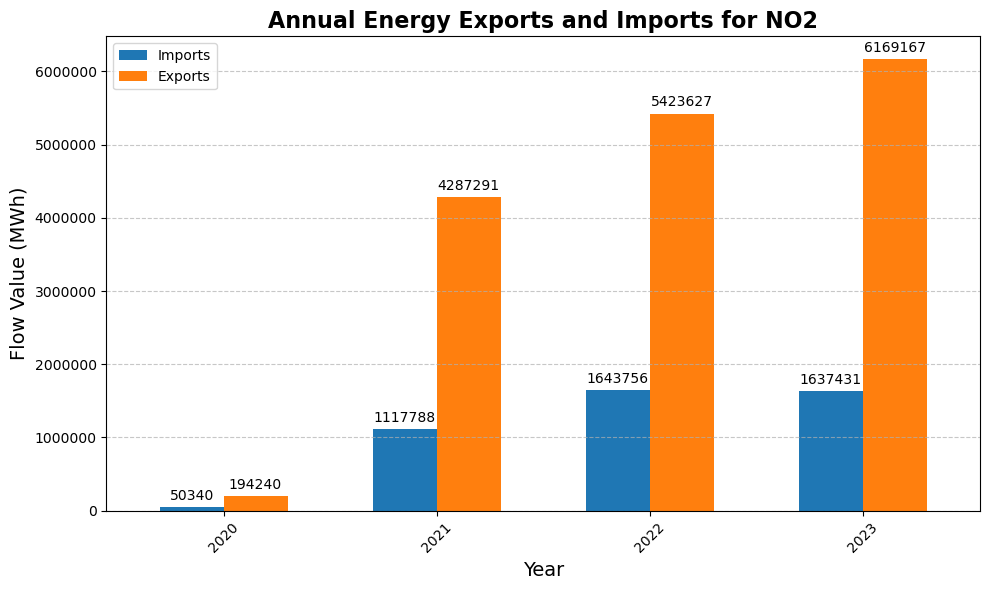

In [19]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

DATA_PATH = './data'
physicalflow_pattern = f'{DATA_PATH}/PhysicalFlows_12.1.G/*.csv'

# Concatenate all files and set DateTime as index
physicalflow = pd.concat(
    (pd.read_csv(file, sep="\t", parse_dates=['DateTime'], index_col='DateTime') for file in glob.glob(physicalflow_pattern)),
    axis=0
).sort_index()

# Filter data for NO2 exports to DE_LU and imports from DE_LU
physicalflow_export = physicalflow[(physicalflow['OutMapCode'] == 'NO2') & (physicalflow['InMapCode'] == 'DE_LU')]
physicalflow_import = physicalflow[(physicalflow['InMapCode'] == 'NO2') & (physicalflow['OutMapCode'] == 'DE_LU')]

# Resample yearly and calculate the sum of FlowValue for exports and imports
exports_per_year = physicalflow_export['FlowValue'].resample('Y').sum()
imports_per_year = physicalflow_import['FlowValue'].resample('Y').sum()

# Calculate net exports
net_exports_per_year = exports_per_year - imports_per_year

# Combine data into a DataFrame for plotting
afs = pd.DataFrame({
    'Exports': exports_per_year,
    'Imports': imports_per_year,
    'Net Export': net_exports_per_year
})

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
bars = afs[['Imports', 'Exports']].plot(kind='bar', color=['#1f77b4', '#ff7f0e'], width=0.6, ax=ax)

# Set title and labels
ax.set_title('Annual Energy Exports and Imports for NO2', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Flow Value (MWh)', fontsize=14)

# Display year only on x-axis
ax.set_xticklabels([year.strftime('%Y') for year in afs.index])

# Automatically add data labels for exports and imports
for container in bars.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=10, color='black')

# Remove scientific notation from y-axis
ax.get_yaxis().get_major_formatter().set_scientific(False)

# Customize grid and layout
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Save as a high-resolution image
plt.savefig('figure_task3.png', format='png', dpi=300)
plt.show()

The diagram clearly indicates that NO2 exports more energy than it imports from Germany. It is also clear that the opening of NordLink has led to an increase in both import and export of electricity. If we take a closer look at the imported electricity, germany reduced their exports in 2023, while increasing their import. This correlates with the shutdown of three nuclear reactors in start of Q2 2023. 

TASK 4

[]

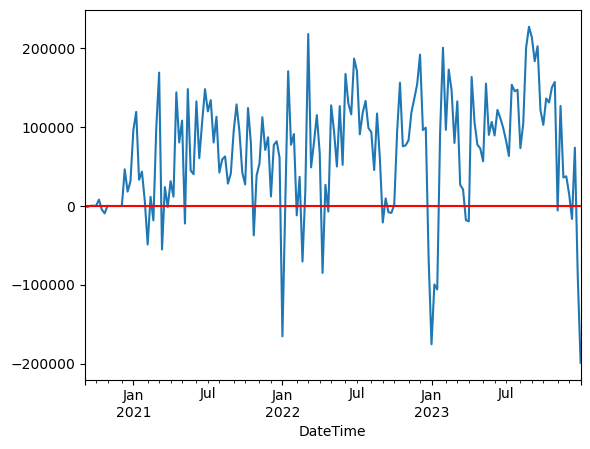

In [23]:
dfe = physicalflow_export['FlowValue'].resample('W').sum()
dfi = physicalflow_import['FlowValue'].resample('W').sum()


# Calculate net exports
dfn = dfe - dfi
dfn.plot.line()
plt.axhline(0, color='red', linestyle='-', label='0')
plt.savefig('figure_task4.png', format='png', dpi=300)  # dpi=300 for high resolution
plt.plot()




Given the graph, there are some clear trends. While NO2 clearly have a positive net export of energy most weeks, there are some instances where Germany exports more. From the graph, those weeks usually are in the winter, and around the change in year. This is a logical trend, due to the cold weather in Norway, thus increasing the electricity demand.  

TASK 5

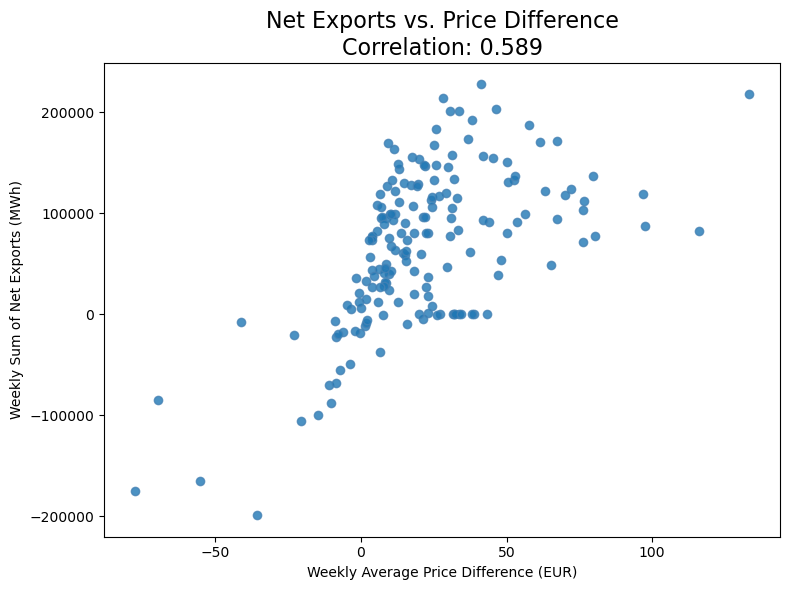

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the weekly average price difference
price_diff = (dfde['Price'] - dfno['Price']).resample('W').mean()

# Calculate the weekly sum of net exports
net_exports = dfn.resample('W').sum()

# Combine into a single DataFrame for plotting and correlation calculation
export_price = pd.DataFrame({
    'Net Exports': dfn,
    'Price Difference': price_diff
}).dropna()

# Calculate the correlation coefficient
correlation = export_price['Net Exports'].corr(export_price['Price Difference'])

# Plot scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(export_price['Price Difference'], export_price['Net Exports'], alpha=0.8, edgecolors='steelblue')

# Add title with correlation coefficient
ax.set_title(f'Net Exports vs. Price Difference\nCorrelation: {correlation:.3f}', fontsize=16)
ax.set_xlabel('Weekly Average Price Difference (EUR)')
ax.set_ylabel('Weekly Sum of Net Exports (MWh)')
plt.savefig('figure_task5.png', format='png', dpi=300)  # dpi=300 for high resolution


# Show plot
plt.tight_layout()
plt.show()

Dont know if this is right? 
Might be smart to double check with other groups. 
Also need to answer the questions

TASK 6

In completing the assignment, we utilized various online resources to complete the tasks and bug fix. 

We frequently used the official documentation of Pandas for guidance on implementing specific functions. For example, the documentation helped us understand how to use the 'resample()' funtion and the 'loc()' function. 
We also used the matplotlib documentaton for the various ways of plotting, and ways to edit and enhance the plots. 

To solve specific issues we tried to google the error, usually a search result from StackOverflow appeared and helped me resolve the error.
We also used ChatGPT to assist with optimalization and trubleshooting. In the rare instance of StackOverflow and the documentation not being able to help me with bug fixing, we consulted ChatGPT. We described the issue to chatgpt and pasted a snippet of my code, which suggested potential causes we had not considered. 

We also sought advice on optimizing a function for better performance and lower runtime. ChatGPT provided us with general strategies and certain concrete changes we could impliment in order to reduce the runtime. An example of such a change was to impliment 

'd = d[(d['ResolutionCode'] == 'PT60M') & (d['MapCode'].isin(['NO2', 'DE_LU']))]'

in the for loop in task 1. 

Throughout the assignement we have ensured that the use of AI or others work were used to enhance our understanding and efficience, and that the core remains our own. We have been very careful to use these tools ethically and resposibly.